In [1]:
from core.datasets import LPDataset
from core.coders import Encoder, Decoder, Reducer
from core.networks import CRNN

import copy

import matplotlib.pyplot as plt
import numpy as np

import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms

In [2]:
CHARACTERS = [
    '_', 'A', 'B', 'C', 'D', 'E',
    'F', 'G', 'H', 'I', 'J', 'K',
    'L', 'M', 'N', 'O', 'P', 'Q',
    'R', 'S', 'T', 'U', 'V', 'W',
    'X', 'Y', 'Z', '0', '1', '2',
    '3', '4', '5', '6', '7', '8',
    '9'
]

In [3]:
preprocess = {
    "train": transforms.Compose([
        transforms.Resize((32, 128)),
        transforms.ToTensor()
    ]),
    "val": transforms.Compose([
        transforms.Resize((32, 128)),
        transforms.ToTensor()
    ])
}

In [4]:
datasets = {
    x: LPDataset(
        root= "./data",
        train = True if x == "train" else False,
        transform = preprocess[x],
        target_transform = Encoder(CHARACTERS),
    )
    for x in ["train", "val"]
}

In [5]:
datasets["train"]

Dataset LPDataset
    Number of datapoints: 10821
    Root location: data
    Split: Train
    Compose(
    Resize(size=(32, 128), interpolation=PIL.Image.BILINEAR)
    ToTensor()
)

In [6]:
datasets["val"]

Dataset LPDataset
    Number of datapoints: 561
    Root location: data
    Split: Test
    Compose(
    Resize(size=(32, 128), interpolation=PIL.Image.BILINEAR)
    ToTensor()
)

In [7]:
dataloaders = {
    x: DataLoader(
        datasets[x],
        batch_size=32,
        shuffle=False,
        num_workers=4
    )
    for x in ["train", "val"]
}

dataset_sizes = {
    x: len(datasets[x])
    for x in ["train", "val"]
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
def imshow(inp, title=None):
    """ Imshow for Tensor """
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp, cmap=plt.cm.gray)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

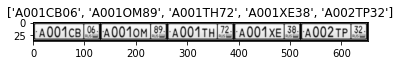

In [9]:
decoder = Decoder(CHARACTERS)
inputs, targets = next(iter(dataloaders["train"]))
out = torchvision.utils.make_grid(inputs[:5])
imshow(out, title=[decoder(target) for target in targets[:5]])

In [10]:
# inputs, targets = next(iter(dataloaders["train"]))
# model = CRNN(32, 1, len(CHARACTERS), 256).to(device)
# inputs = inputs.to(device)
# out = model(inputs)

In [11]:
def train_model(model, criterion, optimizer, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    loss_tracker = {
        'train': [],
        'val': [],
    }

    acc_tracker = {
        'train': [],
        'val': [],
    }

    for epoch in range(num_epochs):
        start = time.time()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, targets in dataloaders[phase]:

                inputs = inputs.to(device)
                targets = targets.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 2)
                    preds = preds.transpose(1, 0).contiguous()

                    input_lengths = torch.full(size=(outputs.size(1),), fill_value=outputs.size(0), dtype=torch.int)
                    target_lengths = torch.full(size=(targets.size(0),), fill_value=targets.size()[1], dtype=torch.int)
                    loss = criterion(outputs, targets, input_lengths, target_lengths)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                reducer = Reducer(targets.size()[1])
                preds = torch.stack([reducer(preds[i]) for i in range(preds.size()[0])]).to(device)
                running_corrects += torch.sum(preds == targets.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / (dataset_sizes[phase] * 8)

            loss_tracker[phase].append(epoch_loss)
            acc_tracker[phase].append(epoch_acc)

            print('{} Loss: {:.4f} - Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        epoch_run_time = time.time() - start
        print(f'epoch running time: {epoch_run_time//60:.03}m {epoch_run_time%60:.03}s')
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, loss_tracker, acc_tracker

In [12]:
model = CRNN(32, 1, len(CHARACTERS), 256).to(device)
criterion = nn.CTCLoss(reduction='mean')
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [13]:
model, losses, accuracies = train_model(
    model,
    criterion,
    optimizer,
    num_epochs=35,
)

Epoch 0/34
----------
train Loss: 3.0755 - Acc: 0.0326
val Loss: 2.9914 - Acc: 0.0105
epoch running time: 0.0m 56.6s

Epoch 1/34
----------
train Loss: 2.5855 - Acc: 0.0887
val Loss: 2.5434 - Acc: 0.0192
epoch running time: 1.0m 1.63s

Epoch 2/34
----------
train Loss: 2.1257 - Acc: 0.1180
val Loss: 2.2388 - Acc: 0.0628
epoch running time: 1.0m 6.18s

Epoch 3/34
----------
train Loss: 1.6166 - Acc: 0.2432
val Loss: 2.6105 - Acc: 0.1348
epoch running time: 1.0m 12.5s

Epoch 4/34
----------
train Loss: 1.1801 - Acc: 0.4449
val Loss: 1.4401 - Acc: 0.3988
epoch running time: 1.0m 16.2s

Epoch 5/34
----------
train Loss: 0.9632 - Acc: 0.4856
val Loss: 1.2616 - Acc: 0.4049
epoch running time: 1.0m 17.3s

Epoch 6/34
----------
train Loss: 0.8565 - Acc: 0.5160
val Loss: 1.0612 - Acc: 0.5795
epoch running time: 1.0m 17.2s

Epoch 7/34
----------
train Loss: 0.5721 - Acc: 0.7375
val Loss: 0.9699 - Acc: 0.7048
epoch running time: 1.0m 18.1s

Epoch 8/34
----------
train Loss: 0.4563 - Acc: 0.8356
v

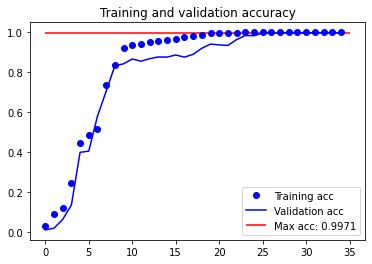

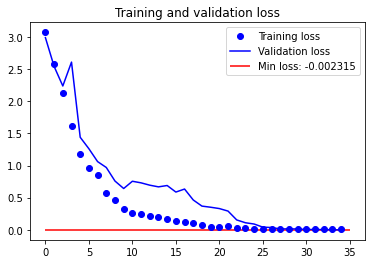

In [14]:
acc = accuracies['train']
val_acc = accuracies['val']
loss = losses['train']
val_loss = losses['val']

epochs = range(len(loss))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.hlines(float(max(val_acc)), xmin=0, xmax=len(acc), colors='r', label=f'Max acc: {float(max(val_acc)):0.04}')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.hlines(float(min(val_loss)), xmin=0, xmax=len(loss), colors='r', label=f'Min loss: {float(min(val_loss)):0.04}')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
def visualize_model(model, reducer, decoder, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 2)
            preds = preds.transpose(1, 0).contiguous()
            
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(decoder(reducer(preds[j].cpu()))))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

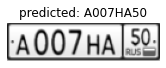

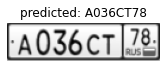

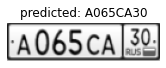

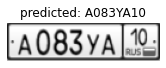

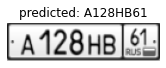

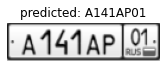

In [16]:
reducer = Reducer(8)
decoder = Decoder(CHARACTERS)
visualize_model(model, reducer, decoder)

In [17]:
torch.save(model.state_dict(), "./save/crnn.pth")